In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from torchvision.models.video import r3d_18
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


## Dataset & Training Loop

In [3]:
class RandomRotation3D(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        """
        Args:
            img (numpy.ndarray): Input 3D image numpy array.

        Returns:
            numpy.ndarray: Randomly rotated image.
        """
        # Randomly select the rotation angle
        angle = np.random.uniform(-self.degrees, self.degrees)

        # Perform rotation
        rotated_img = np.array([np.rot90(slice, k=int(angle / 90)) for slice in img])

        return rotated_img

train_transform = transforms.Compose([
    RandomRotation3D(degrees=5)
])


class AbdominalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Select only the last 64 slices: 
        resized_image = resized_image[-64:, :, :]

        if self.transform:
            resized_image = self.transform(resized_image)
            
        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

    
        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()

        sample = {'x': image, 'y': label}
        return sample



In [4]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, verbose=False):
    acc_dict = {'train': [], 'validate': []}
    loss_dict = {'train': [], 'validate': []}
    best_loss = 1e30
    phases = ['train', 'validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs - 1))
        print('-' * 10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()
                image, label = data['x'], data['y']
                image = image.to(device)
                label = label.to(device)
                outputs = model(image)
                loss = loss_fn(outputs.squeeze(),  label.float())  # Squeeze the output to remove the extra dimension

                if p == 'train':
                    loss.backward()
                    optimizer.step()
                preds = torch.round(torch.sigmoid(outputs)).squeeze()  # Round the sigmoid output to get 0 or 1
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds == label).item()
                running_loss += loss.item() * num_imgs
                running_total += num_imgs

            epoch_acc = float(running_correct / running_total)
            epoch_loss = float(running_loss / running_total)
            if verbose or (i % 10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))

            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    # Calculate F1 score for the validation set
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for data in dataloader['validate']:
            optimizer.zero_grad()
            image, label = data['x'], data['y']
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            preds = torch.round(torch.sigmoid(outputs))  # Round the sigmoid output to get 0 or 1
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(label.cpu().numpy())
            
    val_f1 = f1_score(val_labels, val_preds)

    print('Best F1: {:4f}'.format(val_f1))

    return model, acc_dict, loss_dict


## ResNet18-3D Model

In [5]:
class ResNet18_3D(nn.Module):
    def __init__(self, dropout=0.1):
        super(ResNet18_3D, self).__init__()
        self.resnet18_3d = r3d_18(weights='DEFAULT')

        # Modify stem layer to accept single-channel input
        self.resnet18_3d.stem = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        
        # Change the last fully connected layer
        self.resnet18_3d.fc = nn.Linear(self.resnet18_3d.fc.in_features, 1)
        
        # Add Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Add Batch Normalization
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm3d(64),
            nn.BatchNorm3d(64),
            nn.BatchNorm3d(128),
            nn.BatchNorm3d(256),
            nn.BatchNorm3d(512)
        ])
        
        # Adaptive average pooling
        self.adaptive_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        # Flatten
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.resnet18_3d.stem(x)
        x = self.batch_norms[0](x)
        x = self.resnet18_3d.layer1(x)
        x = self.batch_norms[1](x)
        x = self.resnet18_3d.layer2(x)
        x = self.batch_norms[2](x)
        x = self.resnet18_3d.layer3(x)
        x = self.batch_norms[3](x)
        x = self.resnet18_3d.layer4(x)
        x = self.batch_norms[4](x)
        x = self.adaptive_avg_pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.resnet18_3d.fc(x)
        
        return x

## Train Full Model

In [6]:
bs = 8
lr = 0.0001

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

model = ResNet18_3D().to(device)

pos_weight = torch.tensor(10.0).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight, reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_binary.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/', train_transform), 
           'validate': AbdominalDataset(os.path.join(data_directory, 'val_binary.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/'),
           'test': AbdominalDataset(os.path.join(data_directory, 'test_binary.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/')}

dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True) for x in ['train', 'validate']}

model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs=10, verbose=True)


Epoch: 0/9
----------
Phase:train, epoch loss: 1.2421 Acc: 0.5401
Phase:validate, epoch loss: 1.3434 Acc: 0.2660
Epoch: 1/9
----------
Phase:train, epoch loss: 1.1587 Acc: 0.5685
Phase:validate, epoch loss: 1.3348 Acc: 0.6426
Epoch: 2/9
----------
Phase:train, epoch loss: 1.0780 Acc: 0.5908
Phase:validate, epoch loss: 1.3438 Acc: 0.3872
Epoch: 3/9
----------
Phase:train, epoch loss: 1.0350 Acc: 0.6324
Phase:validate, epoch loss: 1.1517 Acc: 0.5298
Epoch: 4/9
----------
Phase:train, epoch loss: 0.9203 Acc: 0.6823
Phase:validate, epoch loss: 1.2093 Acc: 0.6255
Epoch: 5/9
----------
Phase:train, epoch loss: 0.7756 Acc: 0.7418
Phase:validate, epoch loss: 1.2535 Acc: 0.6319
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6336 Acc: 0.8036
Phase:validate, epoch loss: 1.7218 Acc: 0.8277
Epoch: 7/9
----------
Phase:train, epoch loss: 0.4958 Acc: 0.8548
Phase:validate, epoch loss: 1.6205 Acc: 0.6234
Epoch: 8/9
----------
Phase:train, epoch loss: 0.3884 Acc: 0.9002
Phase:validate, epoch loss: 1.

In [7]:
torch.save(model.state_dict(), 'classification_model_resnet18_binary_0_9_final.pth')

In [8]:
with open('acc_dict_resnet18_binary_0_9_final.pickle', 'wb') as handle:
    pickle.dump(acc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('loss_dict_resnet18_binary_0_9_final.pickle', 'wb') as handle:
    pickle.dump(loss_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluate Model

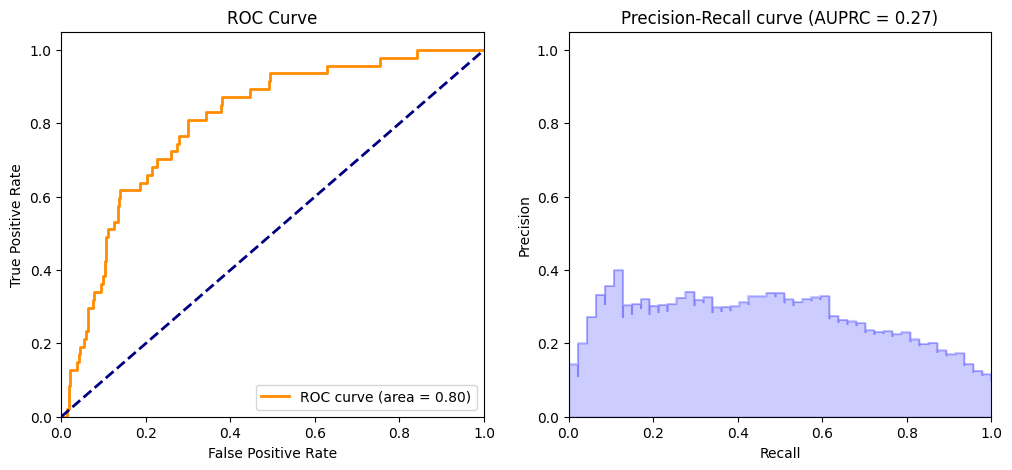

Test F1: 0.28187919463087246
Test AUC: 0.8045556946182728
Test AUPRC: 0.2714887887436925
Test FNR: 0.10638297872340426
Test FPR: 0.49176470588235294


In [11]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([])  # To store predicted probabilities
    all_preds = np.array([])  # To store predicted class labels
    
    with torch.no_grad():
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            probs = torch.sigmoid(outputs).squeeze()
            preds = torch.round(probs) 
            
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate FNR and FPR
    fnr = fn / (fn + tp)
    fpr = fp / (tn + fp)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate AUC score
    fprs, tprs, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fprs, tprs)
    
    # Calculate AUPRC score
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    auprc_score = average_precision_score(all_labels, all_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(fprs, tprs, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (AUPRC = %0.2f)' % auprc_score)
    
    plt.show()
        
    return f1, auc_score, auprc_score, fnr, fpr

eval_dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['test']}

test_f1, test_auc, test_auprc, test_fnr, test_fpr = evaluate_model(model, eval_dataloader['test'], device)
print("Test F1:", test_f1)
print("Test AUC:", test_auc)
print("Test AUPRC:", test_auprc)
print("Test FNR:", test_fnr)
print("Test FPR:", test_fpr)
